In [1]:
import tensorflow as tf 
from tensorflow import keras    
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import read_signal as rs
import tqdm
from matplotlib.animation import FuncAnimation 
# ! pip install tensorflow_addons
import tensorflow_addons as tfa

2024-01-29 10:47:09.314303: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-29 10:47:09.317658: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-29 10:47:09.361599: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-29 10:47:09.361630: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-29 10:47:09.363024: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

Extracting EDF parameters from /home/nima/BraiNeoCare/Datasets/zenodo_eeg/eeg9.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


[ 266 2036 2674] [ 971 2184 2683]


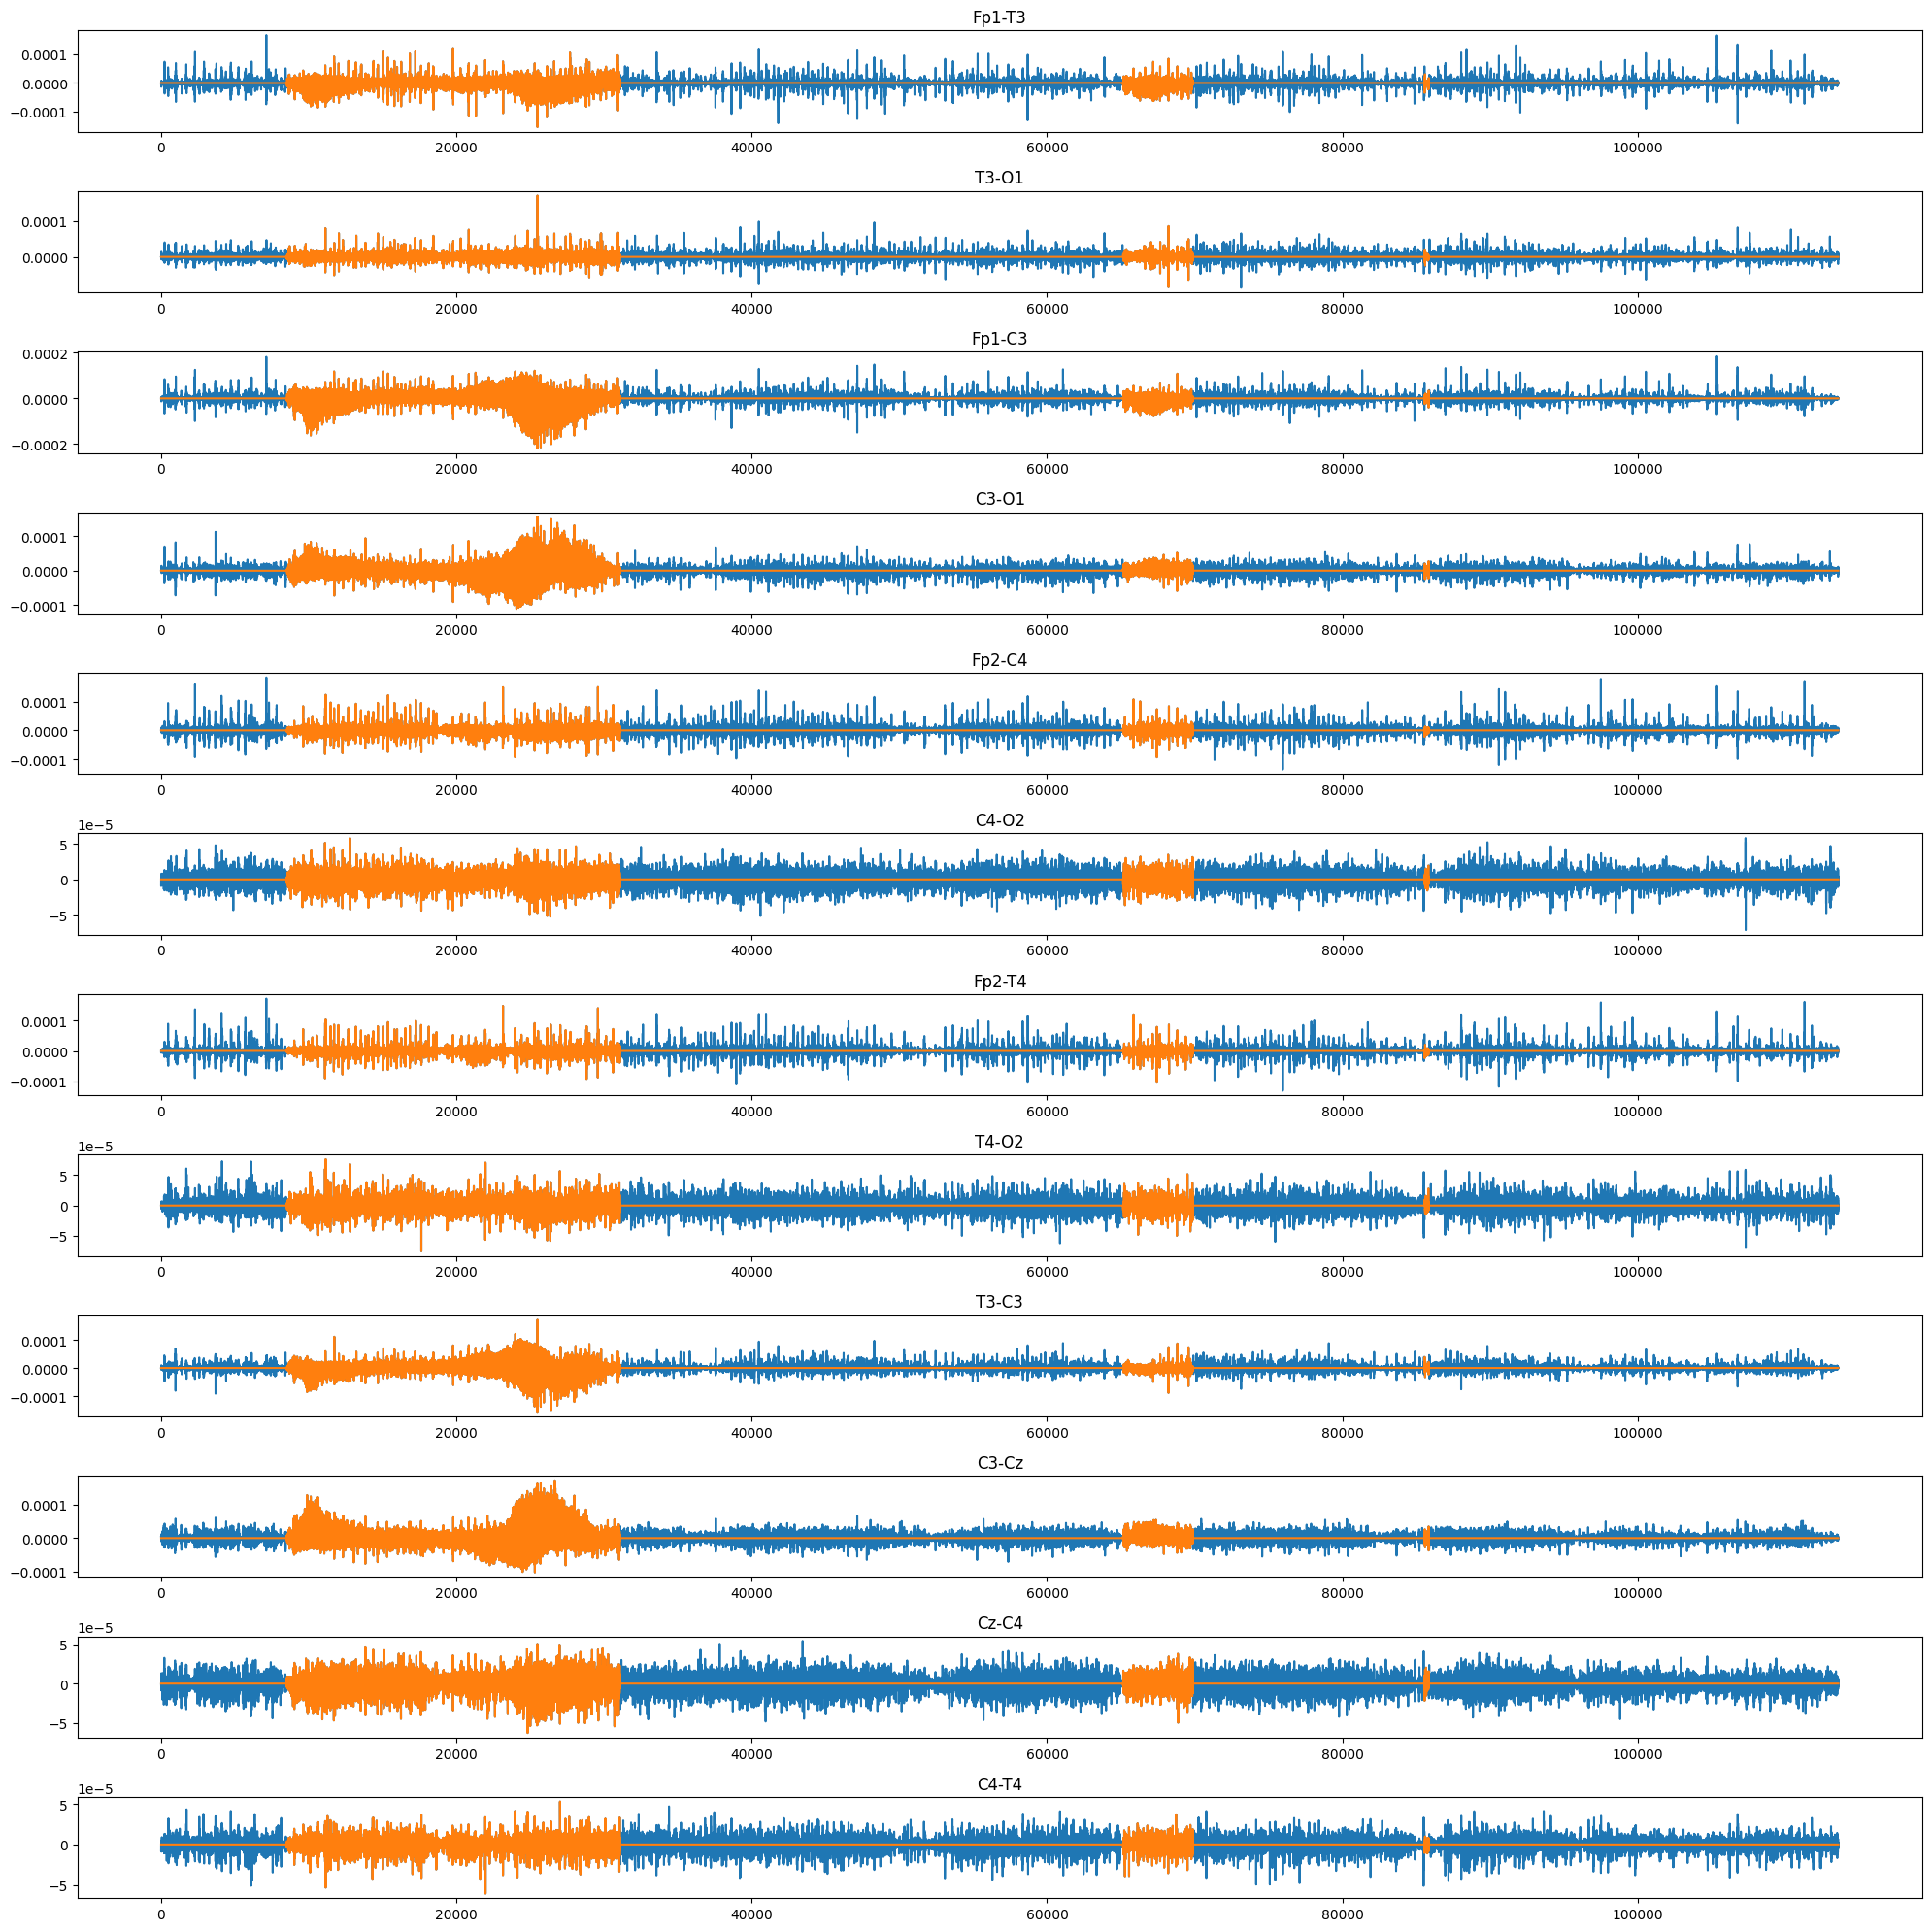

In [2]:
EEG,labels=rs.read_file("../BraiNeoCare/Datasets/zenodo_eeg/eeg9.edf",9)

In [3]:
model = keras.models.load_model("./GAT_model_correct_4/cp_0053.ckpt/")
model.layers[-1].activation = None

2024-01-29 10:47:18.435571: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [4]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 12, 384, 1)]         0         []                            
                                                                                                  
 conv2d_24 (Conv2D)          (None, 12, 384, 32)          192       ['input_4[0][0]']             
                                                                                                  
 conv2d_25 (Conv2D)          (None, 12, 384, 32)          256       ['input_4[0][0]']             
                                                                                                  
 add_12 (Add)                (None, 12, 384, 32)          0         ['conv2d_24[0][0]',           
                                                                     'conv2d_25[0][0]']     

In [5]:
# mean=np.load("mean.npy")
# std=np.load("std.npy")

grad_model = keras.Model(model.inputs,[model.get_layer("gat_layer_11").output,model.output])

def PreprocesSignal(signal,mean,std):
    signal=(signal-mean)/std
    signal=np.expand_dims(signal,axis=-1)
    signal=np.expand_dims(signal,axis=0)
    return signal

def GradCAM(signal,model=grad_model):
    
    with tf.GradientTape() as tape:
        GAT_outputs, predictions = grad_model(signal)
        Class=predictions[:,0]

    grads = tape.gradient(Class, GAT_outputs)

    heatmap = GAT_outputs[0] *  tf.reduce_mean(grads, axis=(0,1,2))

    heatmap = tf.nn.relu(heatmap)/tf.reduce_max(heatmap)

    return heatmap.numpy(),tf.nn.sigmoid(predictions[0][0]).numpy()

In [ ]:
def plot_explainable_signal():

    l, u = 0, 384
    length=EEG.shape[1]
    hmap=np.empty((12,length))
    predicted_class=[]
    x1=PreprocesSignal(EEG)
    
    for r in tqdm.tqdm(range(0,length-384,384),desc="processed GRAD-CAM"):
        h,p=GradCAM(x1[:,:,l:u,:])
        resized_heatmap = cv.resize(h, (384,12), interpolation=cv.INTER_LINEAR)
        hmap[:,l:u]=resized_heatmap
        predicted_class.append(1 if p>=0.5 else 0)
        l+=384
        u+=384 

    return hmap,predicted_class

hmap,prediction=plot_explainable_signal()
prediction=np.array([prediction])
prediction=np.repeat(prediction,384,axis=1)

In [ ]:
channel_names=["Fp1-T3","T3-O1","Fp1-C3","C3-O1","Fp2-C4","C4-O2","Fp2-T4","T4-O2","T3-C3","C3-Cz","Cz-C4","C4-T4"]
fig,ax=plt.subplots(13,1,figsize=(20,30))
length=EEG.shape[1]
EEG1=(EEG-mean)/std
labels1=(labels-mean)/std
ax[0].plot(prediction[0],color='g',linewidth=2)
ax[0].set_title("Model Prediction - 1:Seizure, 0:Non-Seizure")
ax[0].set_ylim(-0.1,1.1)
ax[0].set_xlim(0,length)
for r in range(12):
    ax[r+1].plot(EEG1[r],color='k')
    ax[r+1].plot(labels1[r],color='r')
    im=ax[r+1].imshow(hmap[r].reshape(1,length),cmap='bwr',alpha=0.5,extent=[0,length,EEG1[r].min(),EEG1[r].max()],aspect='auto',vmax=1,vmin=0)
    ax[r+1].set_title(channel_names[r])

fig.tight_layout()
cbar=fig.colorbar(im,ax=ax,orientation='horizontal',pad=0.02,shrink=0.5)
cbar.set_label('Relevance')
plt.show()

In [6]:
x_train=np.load('./Datasets/GAT/traindata.npy')

In [7]:
mean=x_train.mean()
std=x_train.std()    

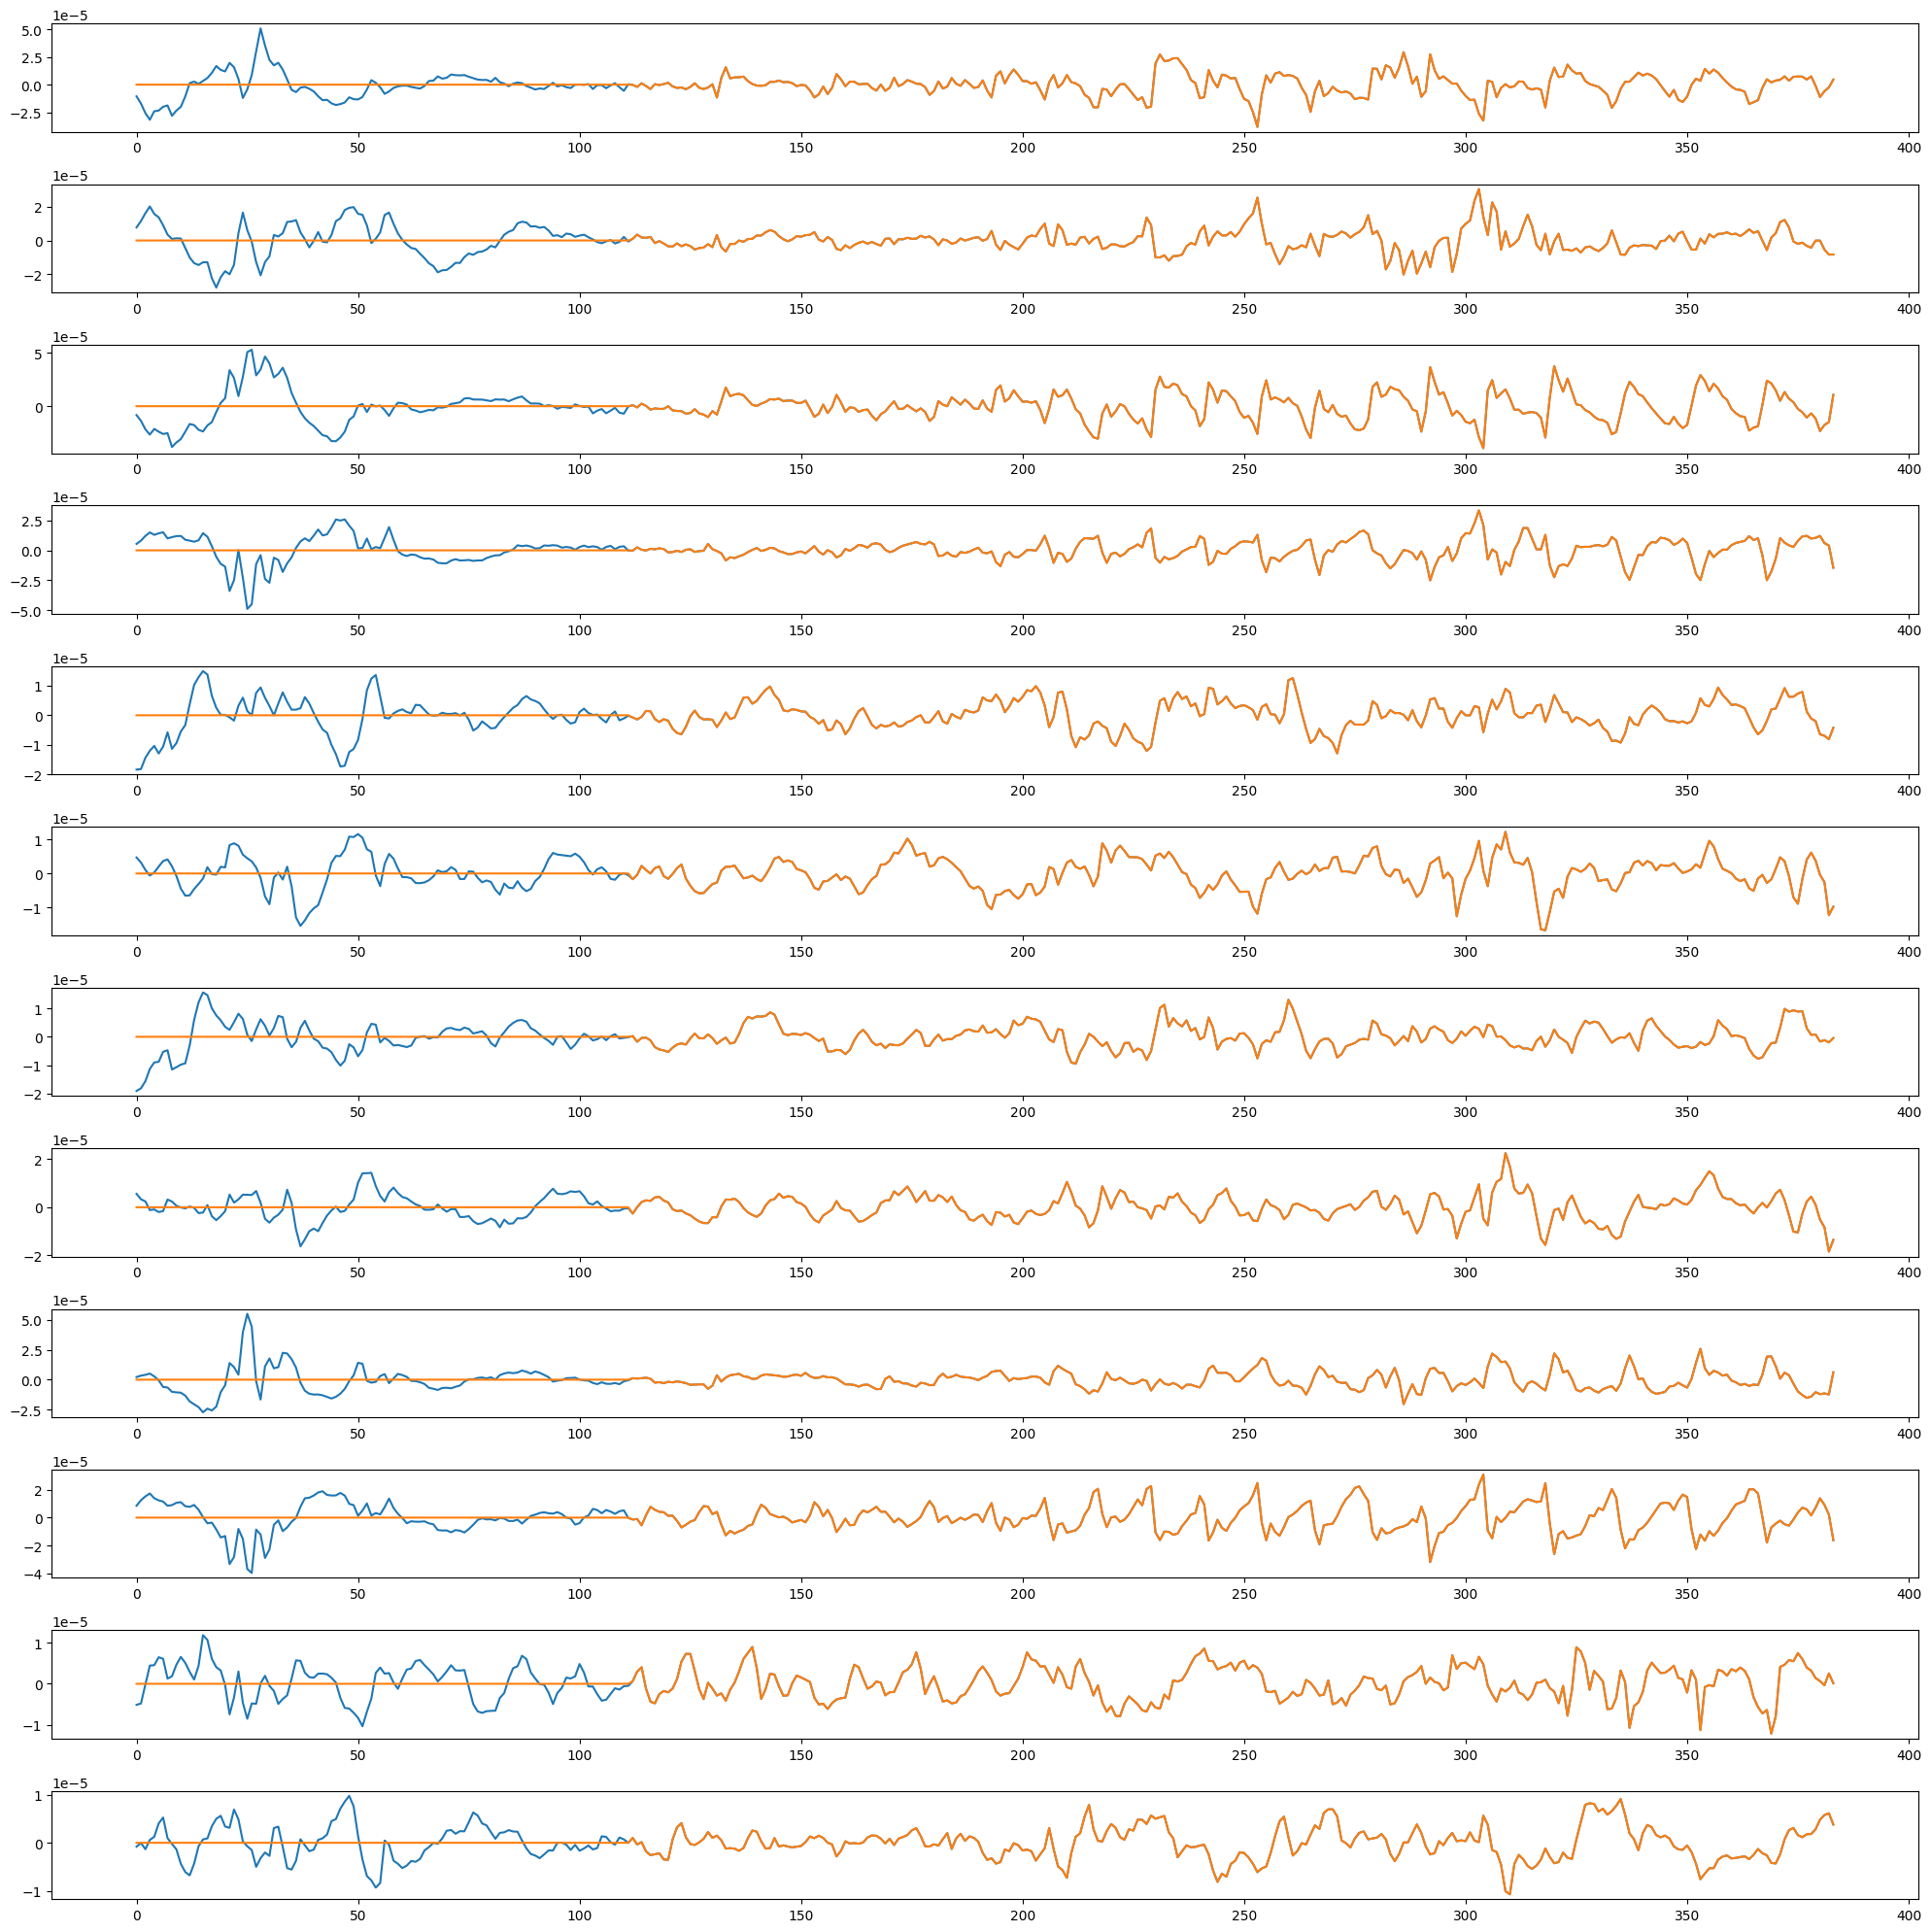

In [11]:
fig,ax=plt.subplots(12,1,figsize=(20,20))
for r in range(12):
    ax[r].plot(EEG[r][8400:8784])
    ax[r].plot(labels[r][8400:8784])
    # ax[r].set_title(channel_names[r])
fig.tight_layout()
plt.show()

prediction:-  1


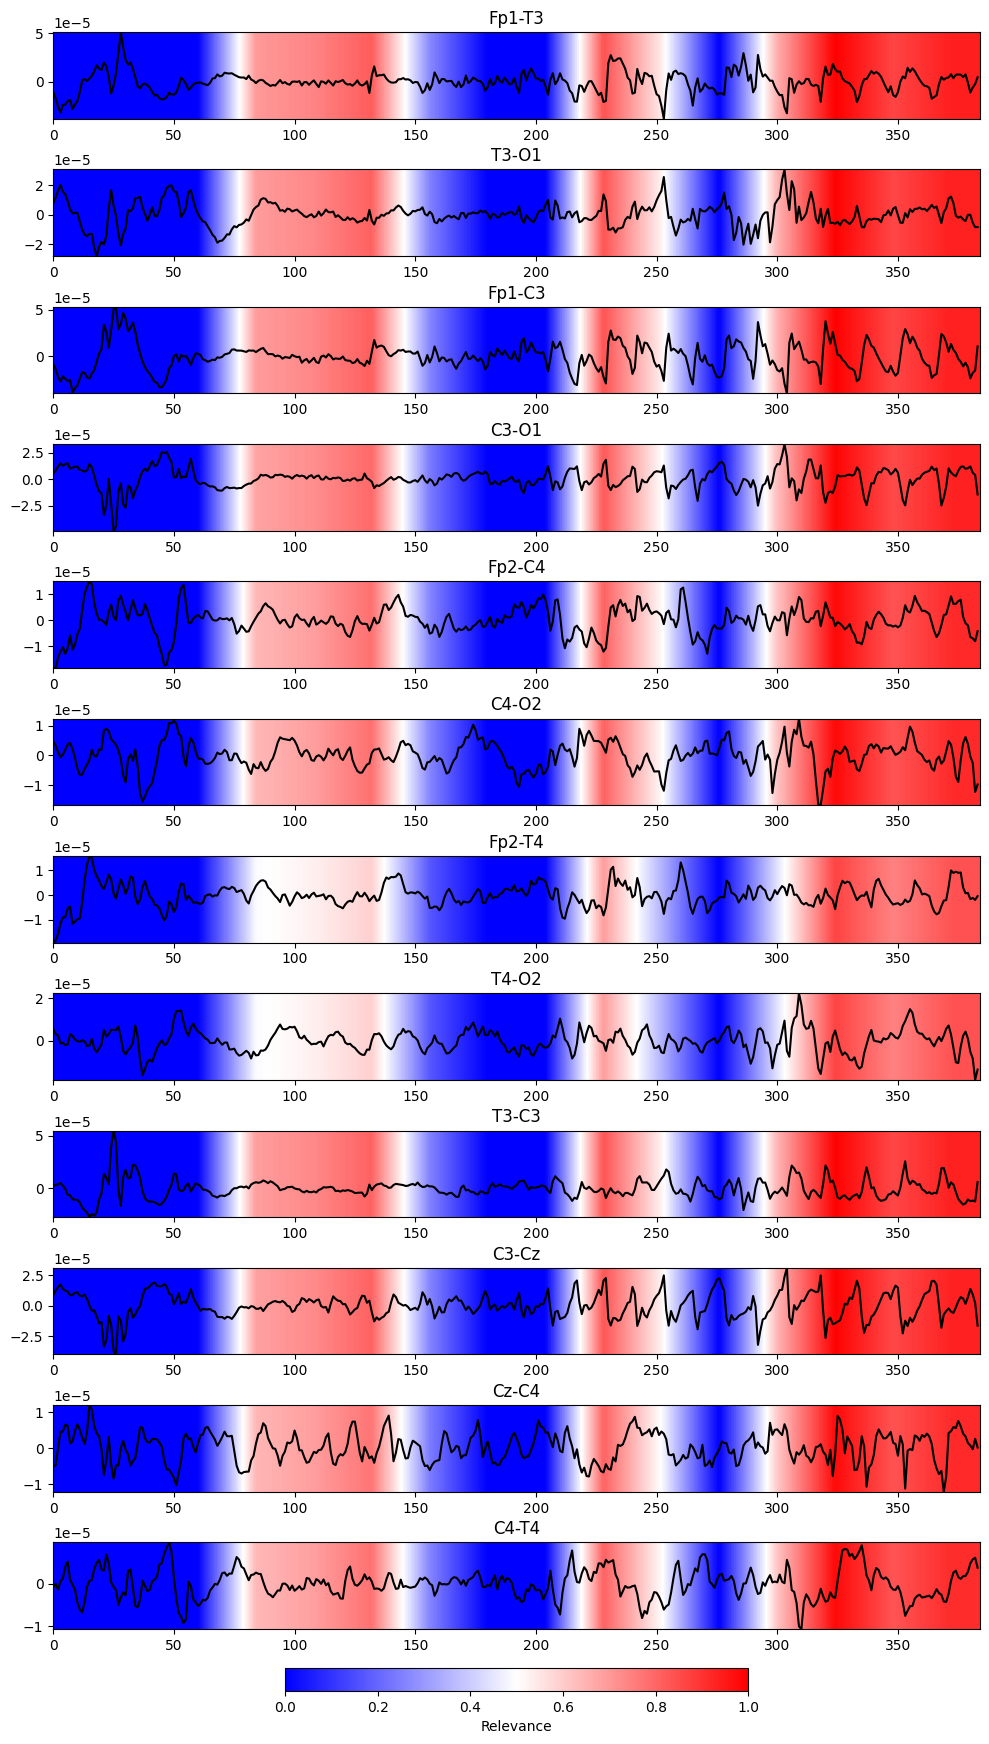

In [20]:
channel_names=["Fp1-T3","T3-O1","Fp1-C3","C3-O1","Fp2-C4","C4-O2","Fp2-T4","T4-O2","T3-C3","C3-Cz","Cz-C4","C4-T4"]
n=3
x=PreprocesSignal(EEG[:,8400:8784],mean,std)
h,p=GradCAM(x)
print("prediction:- ",1 if p>=0.5 else 0)
resized_heatmap = cv.resize(h, (384,12), interpolation=cv.INTER_LINEAR)
fig,ax=plt.subplots(12,1,figsize=(10,20))
for r in range(12):
    ax[r].plot(EEG[r,8400:8784],color='k')
    im=ax[r].imshow(resized_heatmap[r].reshape(1,384),cmap='bwr',alpha=1,extent=[0,384,EEG[r,8400:8784].min(),EEG[r,8400:8784].max()],aspect='auto',vmax=1,vmin=0)
    ax[r].set_title(channel_names[r])   
fig.tight_layout()
cbar=fig.colorbar(im,ax=ax,orientation='horizontal',pad=0.02,shrink=0.5)
cbar.set_label('Relevance')
plt.show()